<img src='https://github.com/LinkedEarth/paleoHackathon/raw/gh-pages/images/LinkedEarth_Square_Small.png' width="100"> 

# Spectral & Wavelet Analysis


## Preamble
Analyzing the frequency content of time series is a critical task in many of the paleosciences. 

In this notebook we demonstrate how to use the spectral analysis features of Pyleoclim using the "ODP846" record described in:

- Mix, A. C., J. Le, and N. J. Shackleton (1995a), Benthic foraminiferal stable isotope stratigraphy from Site 846: 0–1.8 Ma, Proc. Ocean Drill. Program Sci. Results, 138, 839–847.
- Shackleton, N. J. (1995), New data on the evolution of Pliocene climate variability, in Paleoclimate and Evolution, With Emphasis on Human Origins, edited by E. S. Vrba et al., pp. 242-248, Yale Univ. Press, New Haven, CT.

The record was aligned to the Benthic Stack of [Lisiecki & Raymo (2005)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2004PA001071) using the [HMM-Match](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014PA002713) algorithm [(Lin et al, 2017)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2016PA003057).  The latter is a probabilistic method that generates an ensemble of 1000 possible age models compatible with the chronostratigraphic constraints.

## Load the data: Using Chron Data

After invoking some useful packages, we first load the LiPD file containing the data. The file contains information about the PaleoData (in this case sea surface temperature from alkenones) as well as Benthic data. Because the benthic data was used to establish th chronology, the data with its corresponding age is available through the ChronData object. Let's see how we can access series under this object.

In [2]:
import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pyleo.set_style('web')

d = pyleo.Lipd('../data/ODP846.Lawrence.2006.lpd')
ts=d.to_LipdSeries(mode='chron')  # access the series under ChronData

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: ODP846.Lawrence.2006.lpd
3.65 MB :That's a big file! This may take a while to load...
Finished read: 1 record
extracting chronData...
extracting: ODP846.Lawrence.2006
Created time series: 3 entries
0 :  ODP846.Lawrence.2006 :  marine sediment :  depth
1 :  ODP846.Lawrence.2006 :  marine sediment :  age
2 :  ODP846.Lawrence.2006 :  marine sediment :  d18o
Enter the number of the variable you wish to use: 2


Plot the record:

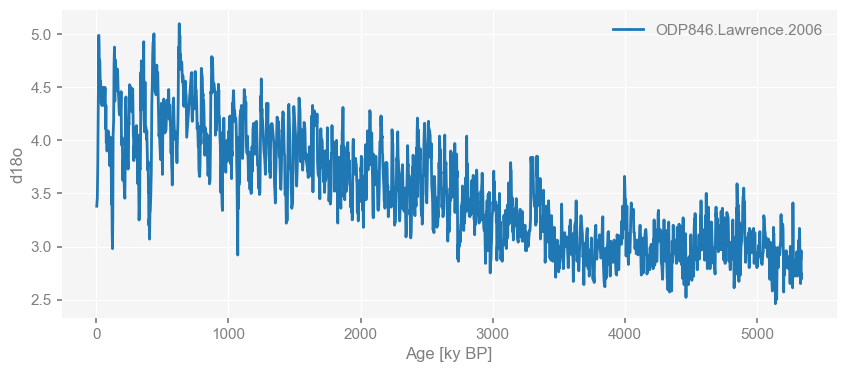

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [ky BP]', ylabel='d18o'>)

In [2]:
ts.plot()

In paleoclimate, it is the norm to flip the d18O axis so warmer is up. 

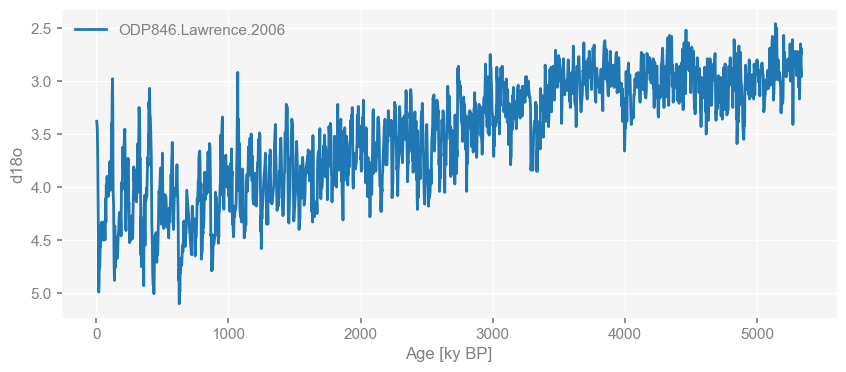

In [11]:
fig,ax=ts.plot(mute=True)
ax.invert_yaxis()
pyleo.showfig(fig)

This paleoclimate record features:

- a long-term cooling trend ($\delta^{18}\mathrm{O}$ gets more positive over time) characteristic of late Neogene and Quaternary.
- some quasi-periodic oscillations (the legendary [Pleistocene Ice Ages](https://www.ncdc.noaa.gov/abrupt-climate-change/Glacial-Interglacial%20Cycles))
- nonstationary behavior, related to the well-known mid-Pleistocene transition from a "41k world" to a "100k world" somewhere around 0.8 Ma [(Paillard, 2001)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2000RG000091).

Now, a standard assumption of spectral analysis is that data are evenly spaced in time. In real-world paleo timeseries this is seldom the case, particularly because of compaction downcore. Let's look at the distribution of time increments in this particular core, as contrained by this tuned age model:

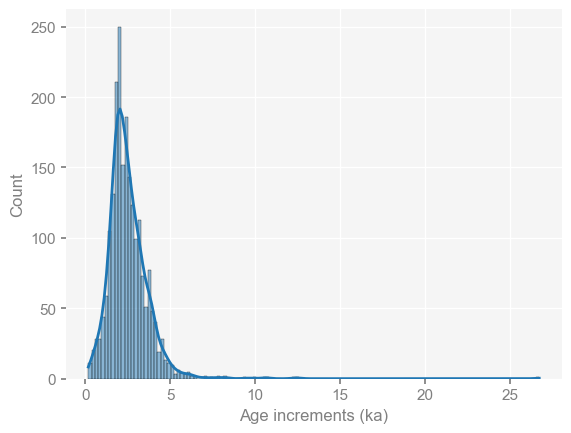

In [4]:
dt=np.diff(ts.time) ## this is equivalent to using (ts.__dict__['time'])
fig, ax = plt.subplots()
sns.histplot(dt,kde=True,ax=ax)
ax.set_xlabel('Age increments (ka)')
pyleo.showfig(fig)

We see that over the past 1 Ma, the time increments are sharply peaked around 2 ka, but they range from 0 to about 7.5 ka. For now, let us assume that the time axis, albeit uneven, is well-known (no uncertainty). 

## Time-certain spectral analysis 
From this point there are two ways to proceed: 1) use methods that explictly deal with unevenly-spaced data, or 2) interpolate to a regular grid and apply standard methods. We will have a look at both options in Pyleoclim.

### Gap-friendly methods

`pyleoclim` offers access to two methods that are tolerant of time gaps (non-uniform spacing): 
- the Lomb-Scargle periodogram as implemented by Scipy with added windowing and weighted overlapped segment averaging (WOSA).
- the Weighted Wavelet Z-transform (Foster, 1996), referred to as WWZ. 

The latter has many interesting properties, particularly in regarding to estimating scaling laws (Kirchner & Neal, PNAS, 2013/ You will be doing an exercise in Notebook 7). However, its current implementation is relatively onerous. This typically isn't an issue for a single estimation, but it makes it impractical for Monte-Carlo assessments of significance (where the spectral estimation is carried out hundreds to thousands of times). 

#### Lomb-Scargle periodogram

First, let's investigate the spectral properties of our time series using the Lomb-Scargle periodogram. We strongly suggest standardizing the time series before analysis. 

In [5]:
psd_ls = ts.standardize().spectral(method='lomb_scargle')

The object returned by this method is of the class [PSD](https://pyleoclim-util.readthedocs.io/en/stable/core/ui.html?highlight=PSD#psd-pyleoclim-psd) (for Power Spectral Density), which comes with various amenities, such as plotting:

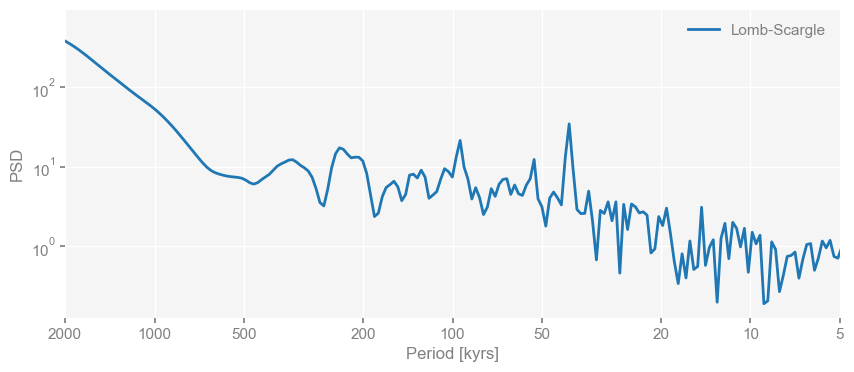

In [6]:
fig, ax = psd_ls.plot(label='Lomb-Scargle')

Again, this was very painless, but we should point out a few things: the plot is expressed in log-log units, so that scaling laws appear as straight lines (see "Model-data confrontation #1", Notebook 7). However, frequency axes are notoriously hard to read, so the abscissa is expressed in terms of the period of oscillation, which is a lot easier to understand for us humans. Finally, notice that the code made use of the units in the LiPD file, and expressed the period in "kyrs". If you prefer "ka", say, this is easily customized with another flick of the wand, but we thought you'd apprediate not to have to micromanage the details to get a decent plot going.    

Lomb-Scargle has several parameters, which can be explored [here](https://pyleoclim-util.readthedocs.io/en/stable/utils/spectral/lombscargle.html#pyleoclim.utils.spectral.lomb_scargle). The Lomb-Scargle implementation in Pyleoclim makes used of te WOSA technique. For the default of n50 =3, the time series is divided into 3 segments with a 50% overlap. The PSD is computed on each segment and averaged. Let's change to n50=1 and n50=5 to see the effect of WOSA on the resulting PSD.

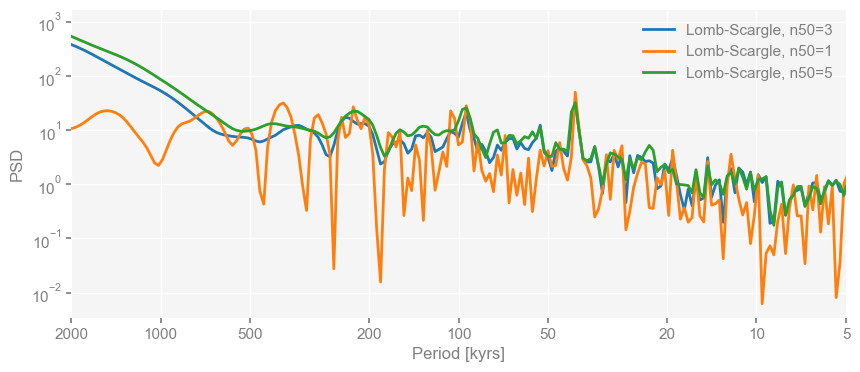

In [7]:
psd_ls_nosegment = ts.standardize().spectral(method='lomb_scargle',settings={'n50':1}) 
psd_ls_fivesegments = ts.standardize().spectral(method='lomb_scargle',settings={'n50':5}) 

fig,ax = psd_ls.plot(label='Lomb-Scargle, n50=3', mute = True)
psd_ls_nosegment.plot(label='Lomb-Scargle, n50=1', mute = True, ax=ax)
psd_ls_fivesegments.plot(label='Lomb-Scargle, n50=5', ax=ax)
pyleo.showfig(fig)

**Exercise**

What is the effect of an increased number of windows?

Another parameter in `Series.spectral` to consider is the method by which the frequency vector is obtained. A description is avilable [here](https://pyleoclim-util.readthedocs.io/en/stable/utils/wavelet/make_freq_vector.html). By default, `Series.spectral` uses the `log` method. Let's explore a few others.

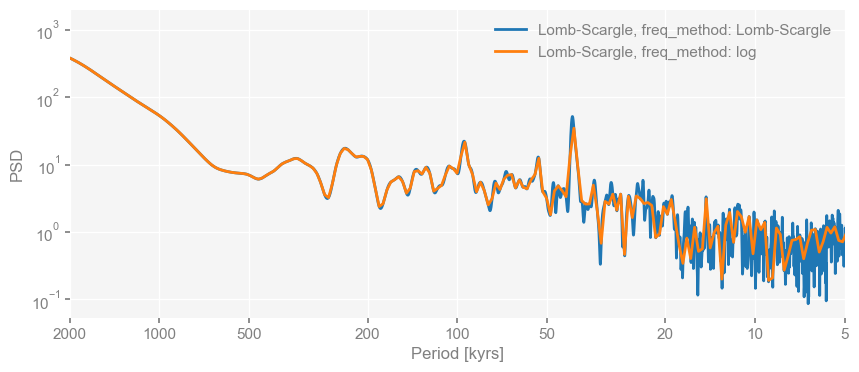

In [8]:
psd_ls_ls = ts.standardize().spectral(method='lomb_scargle',freq_method = 'lomb_scargle')  

fig, ax = psd_ls_ls.plot(label='Lomb-Scargle, freq_method: Lomb-Scargle', mute = True)
psd_ls.plot(label='Lomb-Scargle, freq_method: log', mute = True, ax=ax)
pyleo.showfig(fig)

You can also pass your own frequency vector as such:

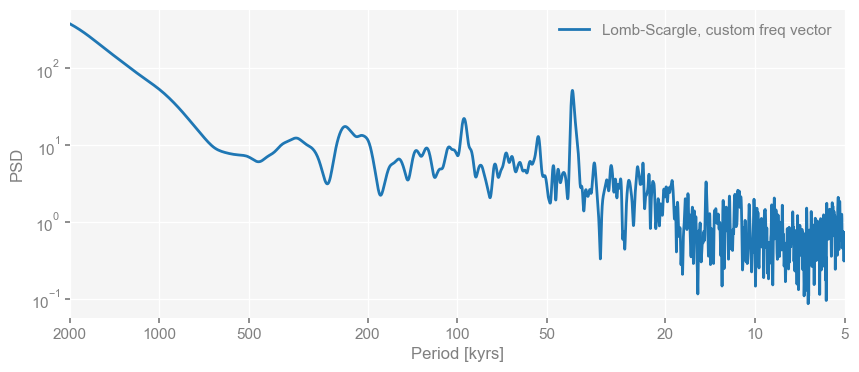

In [9]:
freq =np.linspace(1/2000,1/5,10000)
psd_ls_custom = ts.standardize().spectral(method='lomb_scargle',settings={'freq':freq})

fig,ax=psd_ls_custom.plot(label='Lomb-Scargle, custom freq vector')

#### Estimating significance

One question remains: which of these peaks are significant? Pyleoclim allows users to estimate significance based on an ensemble of AR1 models.

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:02<00:00, 68.69it/s]


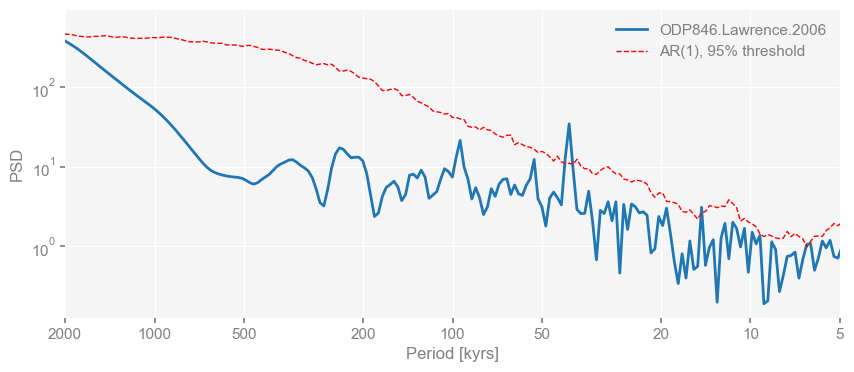

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

In [10]:
psd_ls_signif = ts.standardize().spectral(method='lomb_scargle').signif_test()
psd_ls_signif.plot()

We find a prominent peak at around ~40ky that is significant at the 95% level. Does it hold at 99%?

**Exercise** 

1. Plot the 99% threshold together with the 95% threshold (hint use the `qs` argument).
2. Change the freq_method to Lomb-Scargle (note, this execution will take up to 2 minutes). Does it significantly affect your interpretation?

In [15]:
## your code here

#### Weighted Wavelet Z-transform

Another method to work is unvenly-spaced data is the weighted wavelet Z-transform (Foster, 1996). WWZ is wavelet based and presents several advantages over Lomb-Scargle, chielfy among them is to prevent the reddening of the spectrum, a known drawback from Lomb-Scargle. However, WWZ is computationally expensive and may not be appropriate for exploratory work. Let's compare the results from Lomb-Scargle and WWZ.

In [11]:
psd_wwz=ts.standardize().spectral(method='wwz')

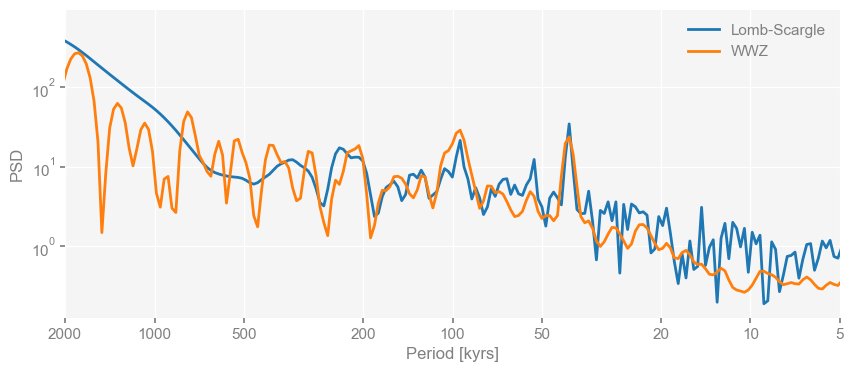

In [12]:
fig,ax = psd_ls.plot(mute=True,label='Lomb-Scargle')
psd_wwz.plot(ax=ax,label='WWZ')
pyleo.showfig(fig)

WWZ is a wavelet-based method, which allow you to understand how power in certain frequency band is distributed over time. Let's run the wavelet version to look at the stability of the 40kyr and 100kyr peak over time.

In [14]:
scal = ts.standardize().wavelet().signif_test(number=10)

Performing wavelet analysis on individual series: 100%|██████████| 10/10 [00:40<00:00,  4.01s/it]


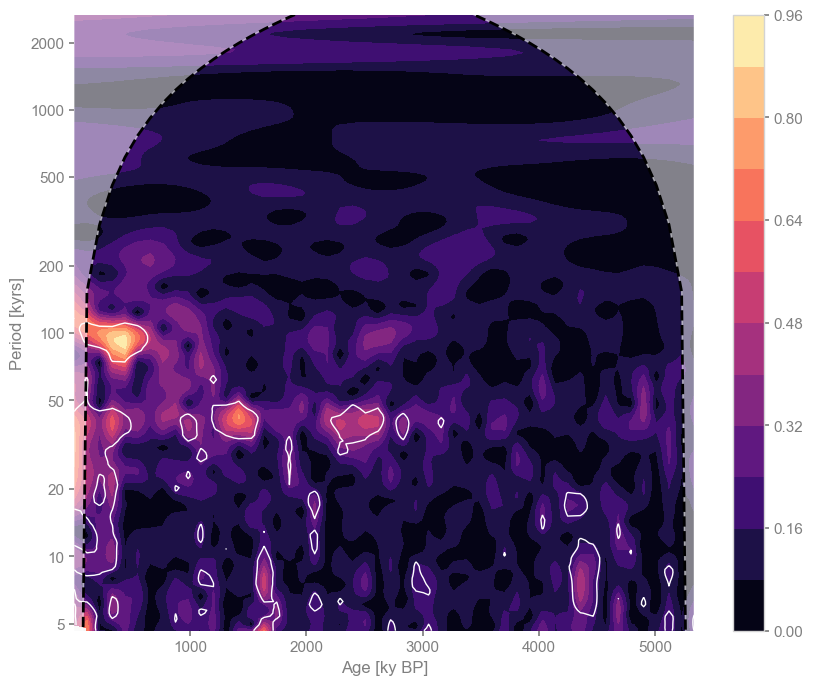

(<Figure size 1000x800 with 2 Axes>,
 <AxesSubplot:xlabel='Age [ky BP]', ylabel='Period [kyrs]'>)

In [15]:
scal.plot()

### Pre-processing steps

Spectral analysis is often considered more of an art than a science since pre-processing steps can have a large influence on the results. Let's take our example: there is a large trend in the record, meaning that any methods that estimate spectral power should result in high energy at low-frequency. This can overwhelm any singificant higher frequency signals.

To deal with this problem, one can remove the long-term trend in the data prior to analysis.

`pyleoclim` offers a few methods for that, explained [here](https://pyleoclim-util.readthedocs.io/en/stable/core/Series/detrend.html). Let us play with the Savitzky-Golay filter, which tends to be rather good at identifying long-term trends, even nonlinear ones:

/Users/deborahkhider/opt/anaconda3/envs/pyleoclim/lib/python3.8/site-packages/pyleoclim/utils/tsutils.py:853: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")


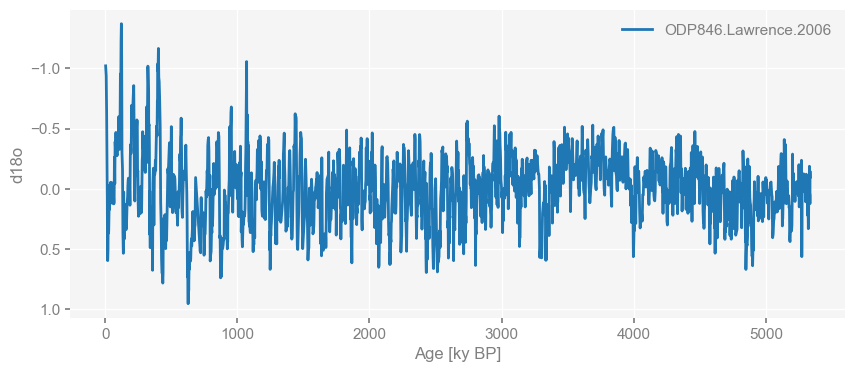

In [3]:
fig,ax=ts.detrend(method='savitzky-golay').plot(mute=True)
ax.invert_yaxis()
pyleo.showfig(fig)

**Exercise**

Explore the various detrending functions in Pyleoclim and plot the resulting timeseries. Choose the one you think is the most appropriate for the dataset for the following exercises.

In [4]:
## your code here

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:03<00:00, 65.68it/s]


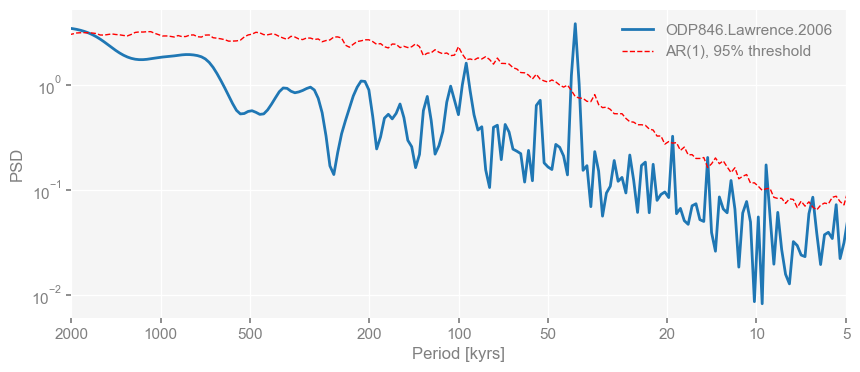

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

In [17]:
tsd = ts.standardize().detrend(method='savitzky-golay').spectral(method='lomb_scargle').signif_test()
tsd.plot()

It is also quite clear that, at least in part because of compaction, the amplitude of glacial cycles decreases strongly going back in time. For our purposes, let us focus on the Pleistocene (the past 900 ka or so). We can do so easily with the method `slice`:

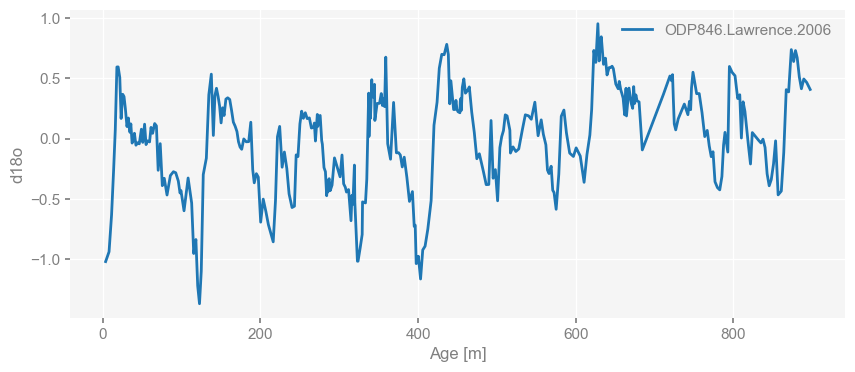

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [m]', ylabel='d18o'>)

In [12]:
tsds = tsd.slice([0,900])
tsds.plot()

Now, we could have performed detrending _and_ slicing in one fellswoop, using a bit of magic called "method composition". Here goes:

In [13]:
tsds = tsd.detrend(method='savitzky-golay').slice([0,900])

this would give the exact same result as before (first detrending, then slicing). Perhaps you'd like to do the opposite? Not an issue; one just permutes the order of operations.

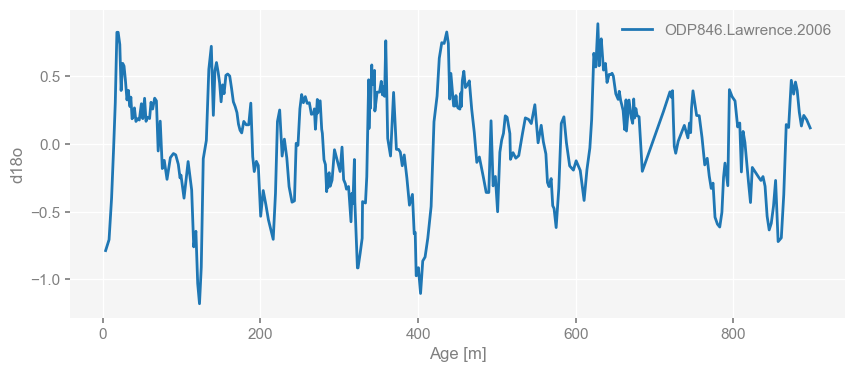

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [m]', ylabel='d18o'>)

In [14]:
tssd = tsd.slice([0,900]).detrend(method='savitzky-golay')
tssd.plot()

No we more clearly see the succession of Pleistocene Ice Ages around a flat baseline (if you except a rather enthusiastic Stage 5e). Let's see what that entails for the spectrum. Once more with feeling:

This conclude 

## Gap-intolerant methods
As mentioned In the second case, we can put the timeseries on a uniformly-spaced timescale (by binning or interpolation), then use a method tailored to evenly-spaced data. 



`pyleoclim` offers a plethora of them: the classic [periodogram](https://pyleoclim-util.readthedocs.io/en/stable/utils/spectral/periodogram.html#utils-periodogram), MTM, and Welch. 

These 